# Fake News Detection using Machine Learning

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
fake = pd.read_csv("Dataset/Fake.csv")
true = pd.read_csv("Dataset/True.csv")

## Shape

In [3]:
print(fake.shape)
print(true.shape)

(23481, 4)
(21417, 4)


## Data Cleaning and preparation

In [4]:
#Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [5]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [6]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)


In [7]:
data.head()

,title,text,subject,date,target
0,U.S. Treasury nominee says would enforce all R...,WASHINGTON (Reuters) - The U.S. Treasury will ...,politicsNews,"January 19, 2017",true
1,"Fearing for post-Brexit prosperity and peace, ...","FLORENCECOURT, Northern Ireland (Reuters) - No...",worldnews,"December 1, 2017",true
2,OBAMA APPOINTED JUDGE Sides With Dems In Criti...,After only serving less than 4 years on the be...,politics,"Oct 17, 2016",fake
3,Factbox: Many years of rhetoric reflect confli...,JERUSALEM (Reuters) - In the 50 years since Is...,worldnews,"December 6, 2017",true
4,U.S. Senate confirms Haley as Trump's U.N. amb...,WASHINGTON (Reuters) - The U.S. Senate voted a...,politicsNews,"January 24, 2017",true


In [8]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,U.S. Treasury nominee says would enforce all R...,WASHINGTON (Reuters) - The U.S. Treasury will ...,politicsNews,true
1,"Fearing for post-Brexit prosperity and peace, ...","FLORENCECOURT, Northern Ireland (Reuters) - No...",worldnews,true
2,OBAMA APPOINTED JUDGE Sides With Dems In Criti...,After only serving less than 4 years on the be...,politics,fake
3,Factbox: Many years of rhetoric reflect confli...,JERUSALEM (Reuters) - In the 50 years since Is...,worldnews,true
4,U.S. Senate confirms Haley as Trump's U.N. amb...,WASHINGTON (Reuters) - The U.S. Senate voted a...,politicsNews,true


In [9]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,WASHINGTON (Reuters) - The U.S. Treasury will ...,politicsNews,true
1,"FLORENCECOURT, Northern Ireland (Reuters) - No...",worldnews,true
2,After only serving less than 4 years on the be...,politics,fake
3,JERUSALEM (Reuters) - In the 50 years since Is...,worldnews,true
4,WASHINGTON (Reuters) - The U.S. Senate voted a...,politicsNews,true


In [10]:
# Convert to lowercase
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,washington (reuters) - the u.s. treasury will ...,politicsNews,true
1,"florencecourt, northern ireland (reuters) - no...",worldnews,true
2,after only serving less than 4 years on the be...,politics,fake
3,jerusalem (reuters) - in the 50 years since is...,worldnews,true
4,washington (reuters) - the u.s. senate voted a...,politicsNews,true


In [11]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [12]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\msaak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
## Data Exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


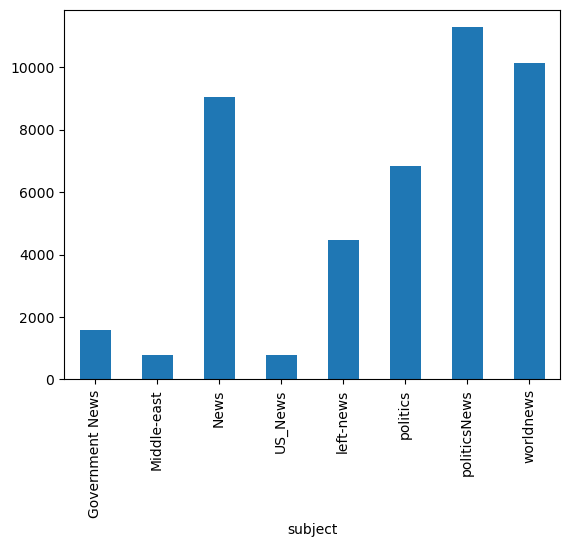

In [14]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()


target
fake    23481
true    21417
Name: text, dtype: int64


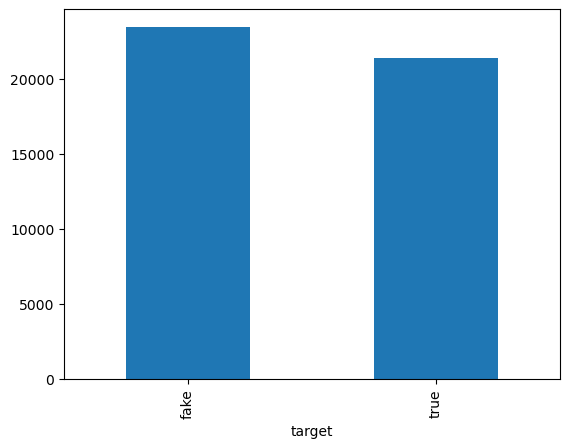

In [15]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [16]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

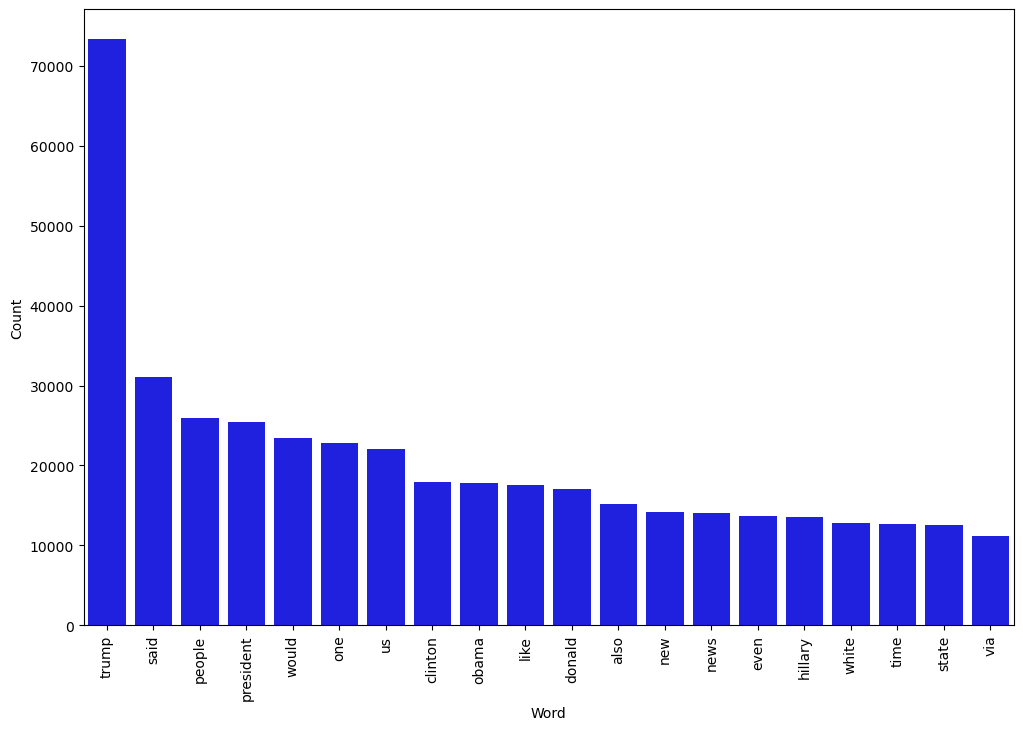

In [17]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

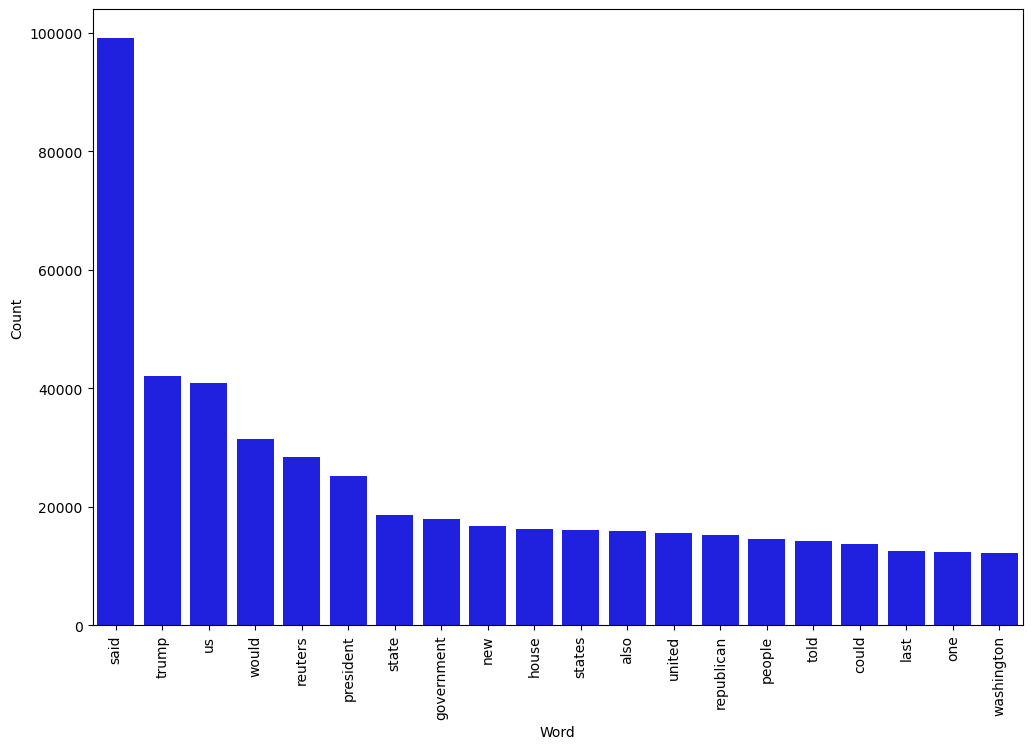

In [18]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Train and Test Split

In [19]:
# Split the data
xtrain,xtest,ytrain,ytest = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

## Naive Bayes Classifier

In [20]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(xtrain, ytrain)
prediction = model.predict(xtest)
print("accuracy: {}%".format(round(accuracy_score(ytest, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(ytest, prediction)*100,2)

accuracy: 95.4%


## Importing necessary libraries for Confusion Matrix

In [21]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay

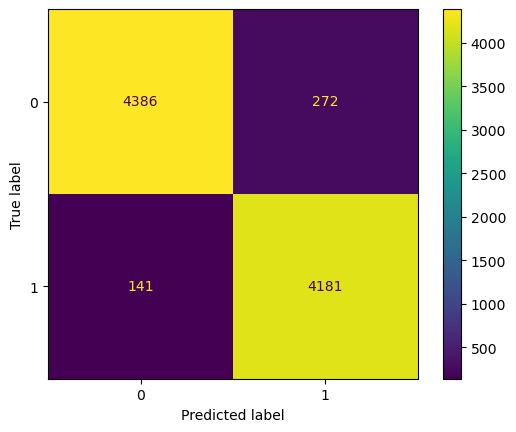

In [22]:
cm = confusion_matrix(ytest, prediction)
ccd = ConfusionMatrixDisplay(confusion_matrix=cm)
ccd.plot()

## Logistic Regression

In [23]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(xtrain, ytrain)

# Accuracy
prediction = model.predict(xtest)
print("accuracy: {}%".format(round(accuracy_score(ytest, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(ytest, prediction)*100,2)

accuracy: 99.11%


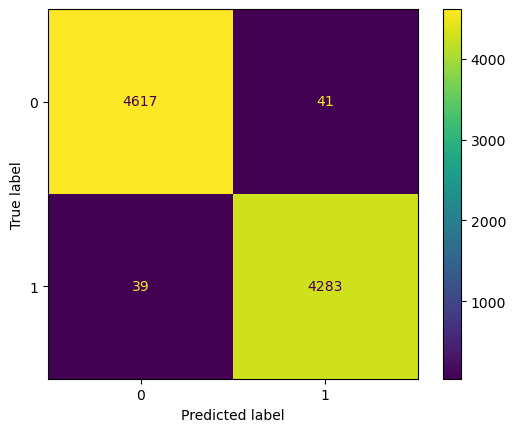

In [24]:
cm = confusion_matrix(ytest, prediction)
ccd = ConfusionMatrixDisplay(confusion_matrix=cm)
ccd.plot()

## Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(xtrain, ytrain)

# Accuracy
prediction = model.predict(xtest)
print("accuracy: {}%".format(round(accuracy_score(ytest, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(ytest, prediction)*100,2)

accuracy: 99.71%


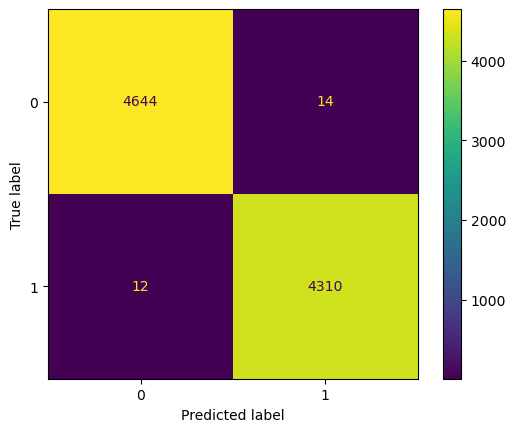

In [26]:
cm = confusion_matrix(ytest, prediction)
ccd = ConfusionMatrixDisplay(confusion_matrix=cm)
ccd.plot()

## Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(xtrain, ytrain)
prediction = model.predict(xtest)
print("accuracy: {}%".format(round(accuracy_score(ytest, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(ytest, prediction)*100,2)

accuracy: 99.01%


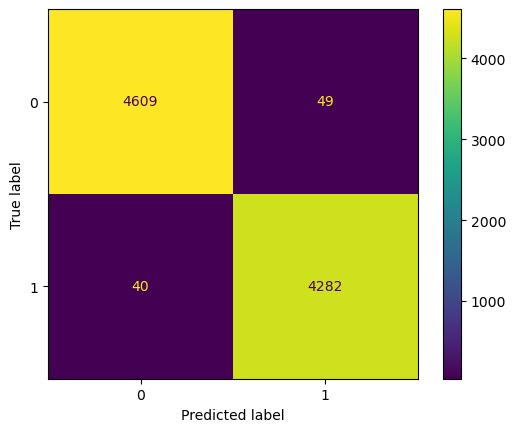

In [28]:
cm = confusion_matrix(ytest, prediction)
ccd = ConfusionMatrixDisplay(confusion_matrix=cm)
ccd.plot()

## SVM 

In [29]:
from sklearn import svm

#Creating a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(xtrain, ytrain)
prediction = model.predict(xtest)
print("accuracy: {}%".format(round(accuracy_score(ytest, prediction)*100,2)))

accuracy: 99.65%


In [32]:
dct['SVM'] = round(accuracy_score(ytest, prediction)*100,2)

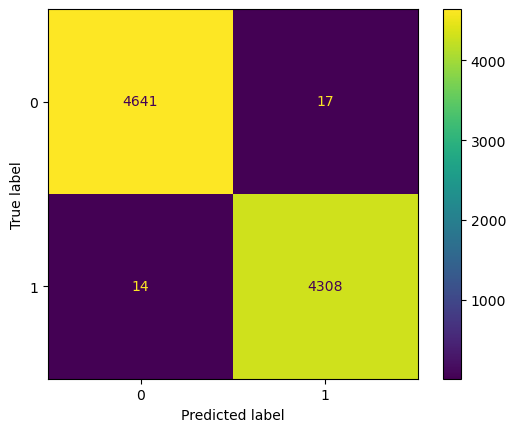

In [33]:
cm = confusion_matrix(ytest, prediction)
ccd = ConfusionMatrixDisplay(confusion_matrix=cm)
ccd.plot()

## Comparing Different Models

([<matplotlib.axis.YTick at 0x22154687b50>,
 [Text(0, 91, '91'),
  Text(0, 92, '92'),
  Text(0, 93, '93'),
  Text(0, 94, '94'),
  Text(0, 95, '95'),
  Text(0, 96, '96'),
  Text(0, 97, '97'),
  Text(0, 98, '98'),
  Text(0, 99, '99'),
  Text(0, 100, '100')])

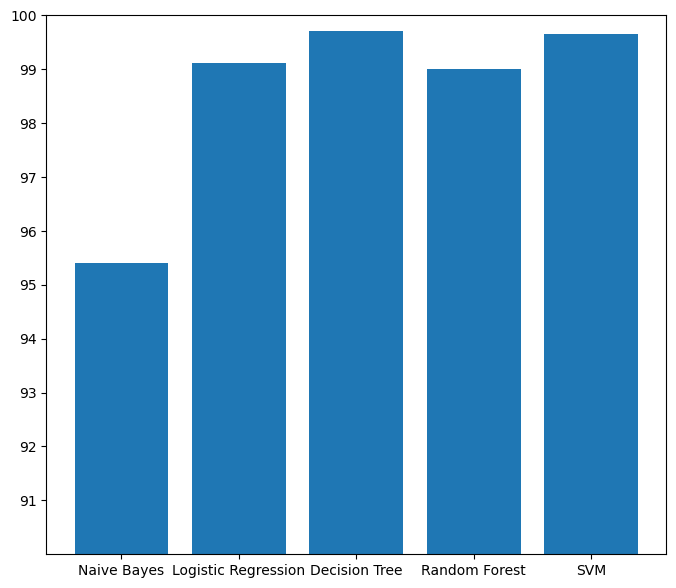

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))